# Dataset Exploration Example

This is a notebook to explore a randomly generated dataset for a challenge I attended some time ago. The dataset consists of 11 columns, 10 feature columns and one label column. 

On this notebook you will find a descriptive and predictive analysis, and it will me made in the following sequence:

#### Descriptive Analysis
**1.** *Peeking at the data* <br>
**2.** *Statistical Summary* <br>
**3.** *Statistical Visualization* <br>
**4.** *Feature Selection* <br>
**5.** *Data Visualization* <br>

#### Predictive Analysis
**6.** *Creating and Training a Model* <br>
**7.** *Choosing the best model*

#### Conclusions
**8.** *Final Conclusions*

### 1. Preeking at the data

Before anything, I examined each column of the dataset and came to the conclusion that the columns 'Fts_0' to 'Fts_10' are explanatory variables and that the column 'Label' is the response variable (aka. our classes).

Now we'll have to check the nature of our explanatory variables:

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

plt.tight_layout()

# Load the data
df = pd.read_csv('dataset.csv')

df.dtypes

Fts_0       int64
Fts_1       int64
Fts_2     float64
Fts_3       int64
Fts_4       int64
Fts_5       int64
Fts_6       int64
Fts_7     float64
Fts_8       int64
Fts_9       int64
Fts_10      int64
Label       int64
dtype: object

### 2.1 Statistical summary of the dataset

As the rows above show us, all the variables from Fts_0 to Fts_10 are continuous. 

Now we can start digging deeper into the data by looking at how the classes (aka. 'Labels') are distributed throughout the dataset and use pandas's describe() method to give us a descriptive statistical summary of the dataset.

In [3]:
# Create features and labels axis
X = df.loc[:, 'Fts_0':'Fts_10']  # Features 0 through 10
y = df.loc[:, 'Label']  # Label
total_classes = y.max()

# Finding out the total number of classes on the dataset
print('We have a total of {} classes and this is how they\'re distributed:\n'.format(total_classes))

# Ordering and looking at how many elements each one the classes have
class_counts = df.groupby('Label').size().sort_values()
for i, v in class_counts.items():
    print('Class {} has {} elements'.format(i, v))
    
# Looking at initial descriptive analysis of the dataset
X.describe().loc[['count', 'mean', 'std', 'min', '50%', 'max'], :].round(3)

We have a total of 7 classes and this is how they're distributed:

Class 6 has 6 elements
Class 7 has 11 elements
Class 2 has 37 elements
Class 3 has 132 elements
Class 5 has 2458 elements
Class 4 has 6748 elements
Class 1 has 34108 elements


,Fts_0,Fts_1,Fts_2,Fts_3,Fts_4,Fts_5,Fts_6,Fts_7,Fts_8,Fts_9,Fts_10
count,43500.000,43500.000,43500.000,43500.000,43500.000,43500.000,43500.000,43500.000,43500.000,43500.000,43500.000
mean,48.250,-0.205,9.200,85.342,0.263,34.529,1.298,6.353,37.075,50.900,13.965
std,12.253,78.143,1.355,8.909,41.004,21.703,179.487,5.480,13.136,21.463,25.648
min,27.000,-4821.000,8.459,21.000,-3939.000,-188.000,-13839.000,0.300,-48.000,-353.000,-356.000
50%,45.000,0.000,8.503,83.000,0.000,42.000,0.000,10.000,39.000,44.000,2.000
max,126.000,5075.000,14.521,149.000,3830.000,436.000,13148.000,12.000,105.000,270.000,266.000


### 2.2 Summary conclusions

We can see that there are 7 different classes and they are very innequally represented. This could be a problem when we try to train a predictive model for this dataset, as the data is very skewed.

Looking individually at the different features that compose this dataset we can see that there are no missing values in any of them (all of them having 43500 rows), some of them have negative values which limits some of the tests that we can make on this dataset, such as  Pearson's chi square test.

We can also see that their minimal and maximum values vary greatly. This varying magnitude can affect performance of some algorithms such as SVM, Logistic Regression or a Neural Network and we might need to normalize the dataset.

### 3.1 Statistical Visualization

We should visualize the features individually to get a better understanding of them.

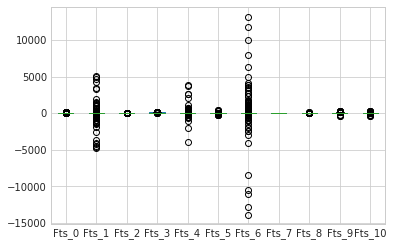

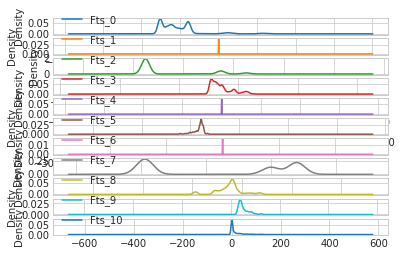

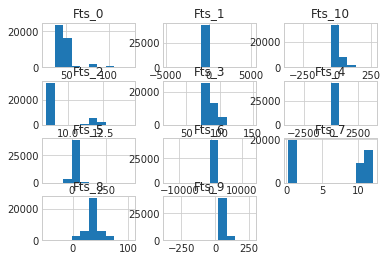

In [16]:
sns.set_style("whitegrid")

plt.rcParams["figure.figsize"] = (6, 4)  

# boxplot
X.boxplot()

# density
X.plot(kind='density', subplots=True, sharex=False)
plt.show()

# histograms
X.hist()
plt.show()

### 3.2 Visualization Conclusions

Looking at the boxplot we can see that all of the features have negative values and Fts_1,Fts_4 and Fts_6 are the features that have the most outliers, and they are all very sparse.

Comparing the density plot with the boxplot we can safely conclude that there won't have any negative implications to the dataset if we were to remove the previously mentioned outliers. The only thing we should take into consideration is if any of those outliers is within a class that doesn't have many elements in it.

Analyzing the density plots and histograms we can see that Fts_2 and Fts_8 are similar to a gaussian distribution.

### 4.1 Feature Selection

Now that we have a better insight of our dataset, we should see how each feature correlates with each other. To do that we'll use a **Correlation Matrix** and do feature extraction with the **Extra Trees** algorithm to see the importance of each feature and how each of them affects our classes.

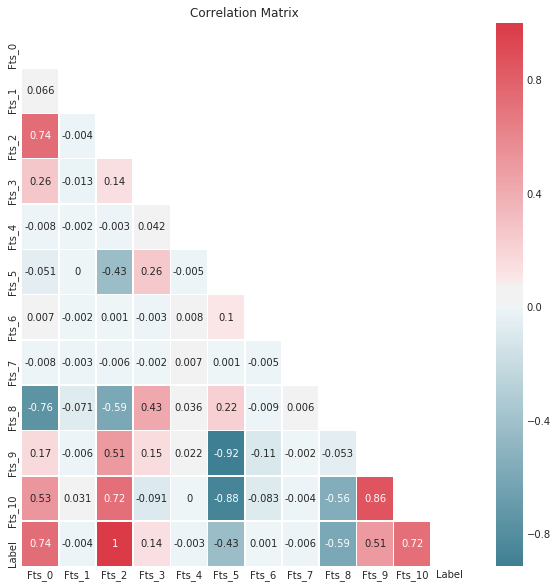

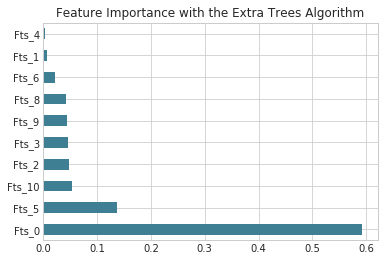

In [17]:
# get correlations of each features in dataset
corrMtrx = df.corr()
top_corr_features = corrMtrx.index

# Generate a mask for the upper triangle
mask = np.zeros_like(corrMtrx, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(10, 10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# plot heat map
correlations = df[top_corr_features].corr().round(3)
#print(correlations.loc['Label', :].nlargest(10))

g = sns.heatmap(correlations, mask=mask, annot=True,
                cmap=cmap, linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

# Feature Extraction with ExtraTrees
model = ExtraTreesClassifier()
model.fit(X, y)
# print(model.feature_importances_)  # use inbuilt class
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh', cmap=cmap)
plt.title('Feature Importance with the Extra Trees Algorithm')
plt.show()

### 4.2 Feature Selection Conclusions

First with the correlation matrix, the red squares represent the positive correlations (increase in one feature value inscreases the target variable) and the blue squares represent the negative correlations (increase in one feature value decreases the target variable). Looking at the 'Label' row we can see that the features that most affect our classes are Fts_2, Fts_0, Fts_10, Fts_9, Fts_8 and Fts_5.

Now looking at the feature importance graph from the Extra Trees algorithm result, we can confirm that those features are indeed the most important to the classification of this dataset. 

### 5.1 Data Visualization

It should be usefull to **visualize** the most important features of our dataset. 

We could use some dimensionality reduction technique such as *PCA* or *T-SNE* to lower from 11 to 2 dimensions and plot a graph to visualize the data (and even get more insight on feature selection with PCA), but as our heatmap and feature importance bar graph indicate, FTS_2 and FTS_0 seems to be the ones that have the most impact on the labelling of the dataset. So instead of doing some fancy dimensionality reduction, let's do a multivariate plot of the most important features first.

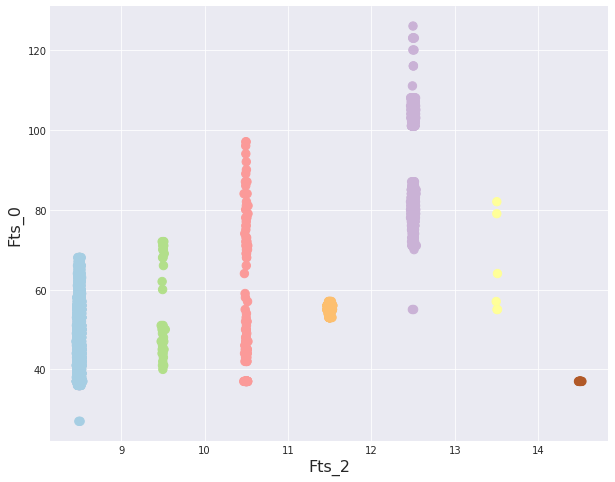

In [31]:
# Our selected features and labels
x = df['Fts_2']
y = df['Fts_0']
labels = df.loc[:, 'Label']

sns.set_style("darkgrid")
plt.rcParams["figure.figsize"] = (10, 8)  
plt.scatter(x, y, c=labels, cmap='Paired', s=70)

plt.xlabel('Fts_2', fontsize=16)
plt.ylabel('Fts_0', fontsize=16)

plt.show()

### 5.2 Top Features Visualization Conclusions

As our scatter plot above shows us, all of our 7 labels are perfectly divided using Fts_0 and Fts_2. To have all classes linearly separated in such a perfect manner is quite surprising!

### 6.1 Creating and Training a Model

Now that we have a bigger insight into the data, we can start building a predictive model of the dataset. 

For this model I will keep things as simple as possible. We will use Fts_0 and Fts_2 as we discovered they are the best features, and use 80% of the dataset for training and the remaining 20% for validation. 

We will try  three different algorithms: two 'simpler' ones (Linear Regression and K-Nearest Neighboors) and a more computational costly one (Support Vecotr Machine). Those algorithms will be evaluated on accuracy.

In [35]:
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# Selecting the features that will be used to test the algorithms
x = df[['Fts_2', 'Fts_0']].values
y = labels

# Creating the validation dataset
validation_size = 0.20 # 80% for training, 20% for validation
seed = 7
X_train, X_validation, Y_train, Y_validation = model_selection.train_test_split(
    x, y, test_size=validation_size, random_state=seed)

# Building the models
models = []
models.append((' LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('SVM', SVC(gamma='auto')))
models.append(('KNN', KNeighborsClassifier()))

# Running each model and getting their accuracy
results = []
names = []
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_results = model_selection.cross_val_score(
        model, X_train, Y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    print('{} - Accuracy: {}, Error: {}'.format(
        name, cv_results.mean().round(6), cv_results.std().round(6)))


 LR - Accuracy: 0.994971, Error: 0.001386
SVM - Accuracy: 0.99954, Error: 0.000345
KNN - Accuracy: 0.998592, Error: 0.000827


### 7.1 Choosing the best Model

As we can see above, all of the algorithms have almost perfect accuracy, with SVM ranking first, KNN second and lastly LR. Now, choosing the best model in a situation like this requires a deeper evaluation and it depends on other external factors, such as needing a solution with more computer power or not. But for the moment, any of them seem like a great choice because Fts_0 and Fts_2 are features that are separating our labels almost in a perfect manner.

Of course we should do more tests, check for the risk of overfitting and do a deeper comparison between the algorithms, but for this dataset I'm satisfied with the current results!

### 8.1 Final Conclusions

I tried to go as deep as possible into the dataset and use the data itself to tell a story of discovery as I dug deeper into the analysis, with each new finding trying to justify my next train of thought. There were many braching paths that I could've taken, I could have normalized the entire dataset, I could have used all the features for the algorithms and so on. 

One of the biggest challenges was that the dataset was given in a very generalist manner, with all of the columns having no "real world" meaning to them. Finding out that Fts_0 and Fts_2 were such relevant features lead me to use them for building a model and choosing the algorithms. In the end it was announced that the labels where generated from a function applied on Fts_2, that's why this feature was selected as the most important one.

It was a fun experience to review many concepts that I've learned and try to express them on this challenge! 